<h1 style="color: #8A2BE2">Title : Predicting Term Deposit Subscriptions using Machine Learning


**By:** *Lohith Basavanahalli Anjinappa*  
**Project Goal:** Build a machine learning model to predict whether a bank client will subscribe to a term deposit based on their profile and past interactions. The objective is to support marketing efforts by identifying likely subscribers ahead of time.

This end-to-end project includes data cleaning, exploratory data analysis (EDA), feature engineering, handling class imbalance, training multiple models, hyperparameter tuning, and evaluation using real-world metrics.  
The dataset is highly imbalanced and reflects a realistic marketing problem faced by financial institutions

<h1 style="color: red">Introduction</span>


This notebook covers:
- Data loading and cleaning
- Exploratory Data Analysis (EDA)
- Feature engineering and preprocessing
- Handling imbalanced data using SMOTE
- Model training and evaluation (Logistic Regression, Random Forest, Gradient Boosting, XGBoost)
- Visualizations and performance comparisons

Dataset: [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
            (https://archive.ics.uci.edu/dataset/222/bank+marketing)
            

<h1 style="color: red">Importing Libraries</span>

In [6]:
import pandas as pnd                                      # For Data Loading and Exploration
import numpy as npy                                       # For Numerical Operations
import matplotlib.pyplot as mplt                          # For Data Visualisation
import seaborn as sea                                     # For Data Visualisation

from sklearn.model_selection import train_test_split      # For Spliting dataset 

from sklearn.preprocessing import StandardScaler          # For Standardising the Numerical Values
from sklearn.preprocessing import LabelEncoder            # For Converting Categorical Variables in to Numerical Values

from imblearn.over_sampling import SMOTE                  # For SMOTE Technique

from sklearn.linear_model import LogisticRegression       # For LR Model
from sklearn.ensemble import RandomForestClassifier       # For RF Model
from sklearn.ensemble import GradientBoostingClassifier   # For GB Model
import xgboost as xgb                                     # For XGB Model

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

#Imports for Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import f1_score

from IPython.display import display

import os                                                # For Interacting with Operating System such as to create folders etc
import re                                                # For Regular expressions usage

# For Surpassing non crital warnings
import warnings
warnings.filterwarnings('ignore') 

# For Setting the random seed for reproducibility
npy.random.seed(42)


## Dataset Overview

I have used the Bank Marketing dataset from the UCI repository. It contains information about 45,211 marketing campaigns.

- 16 input variables: age, job, marital status, education, contact type, previous outcomes, etc.
- 1 target variable: `y` — whether the client subscribed to a term deposit.

First, I will load and inspect the dataset:

<h1 style="color: red">Loading the Data</span>

In [9]:
def loading_the_csv_dataset(filepath):
    """
    This function loads the csv data
    """
    try:
        df = pnd.read_csv(filepath, encoding='utf-8', delimiter=';')
        print("Data loaded successfully. Shape:", df.shape)
        print("\n")
        info = df.info()
        display(info)
        print("\n")
        head = df.head(5)
        display(head)
        return df
    except FileNotFoundError:
        print(f"File not found. Please make sure ---- '{filepath}' ---- exists.")
        return None
    except pnd.errors.ParserError:
        print(f"Failed to parse '{filepath}'. Please check the file format.")
        return None

## Data Cleaning

I will clean the data by cleaing column names, remove duplicates, and handle missing or placeholder values (`'unknown'`, `'NA'`, etc.). For categorical features, we replace `'unknown'` with the mode.


<h1 style="color: red">Cleaning the Dataset</span>

In [12]:
def basic_cleaning_of_the_dataset(df):
    """
    This function clean the dataset
    """
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')                   # Cleaning the column names
    df.columns = df.columns.map(lambda x: re.sub(r'\W+', '_', x))         
    df = df.loc[:, ~df.columns.str.contains('^unnamed')]                                    # Removing the unnamed Column
    df = df.drop_duplicates()                                                               # Droping the duplicates
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)                    # Removing the whitespaces from data
    
    missing_placeholders = ['', 'NA', 'null', '-', 'N/A']  
    found_any = False
    print("\n")
    for placeholder in missing_placeholders:
        count = (df == placeholder).sum().sum()
        if count > 0:
            print(f"Replacing {count} '{placeholder}' values with pd.NA")
            found_any = True
    if not found_any:
        print(f"There are no Null Values ")
    df.replace(missing_placeholders, pnd.NA, inplace=True)                                  # Replacing missing values with NA

    categorical_cols = df.select_dtypes(include=['object']).columns                         # Replacing the Value "Unkonwn" with mode value
    print("\n")
    for col in categorical_cols:
        if 'unknown' in df[col].values:
            count = (df[col] == 'unknown').sum()
            mode_value = df[col][df[col] != 'unknown'].mode()[0]
            df[col] = df[col].replace('unknown', mode_value)
            print(f"Replacing {count} 'unknown' values in '{col}' with mode: '{mode_value}'")    
    return df

## Exploratory Data Analysis (EDA)

Next, I will examine the distribution of the target variable and features, identify outliers, and understand relationships between variables.


<h1 style="color: red">EDA - Exploratory Data Analysis</span>

In [15]:
def summary_stats(df):
    """
    This function will generate summary stats
    """
    print("\nSummary Statistics:")
    stats = df.describe(include='all').round(2)                                                            # Basic Statistics
    display(stats)

In [16]:
def target_distribution(df, target_var):
    """
    This function will generate class distribution count and distribution chart of target variable
    """
    print("\n" + "="*30)
    print("EDA: Distribution of Target Variable (Subscription to Term Deposit)")
    print("="*30 + "\n")
    
    print("Value Counts:\n", df[target_var].value_counts())
    print("Class Proportions:\n", df[target_var].value_counts(normalize=True).round(3)*100)
    
    mplt.figure(figsize=(8, 6))                                                                   # Distribution of target variable
    sea.countplot(x=target_var, data=df)
    mplt.title('Distribution of Target Variable (Subscription to Term Deposit)')
    mplt.xlabel('Subscription')
    mplt.ylabel('Count')
    mplt.savefig('plots/eda/target_distribution.png')
    #mplt.show()
    mplt.close()


In [17]:
def histogram_for_numeric_values(df, numeric_cols):
    """
    This function will generate histograms of numeric values
    """

    print("\n" + "="*30)
    print("EDA: Histogram of Numeric Features")
    print("="*30 + "\n")
        
    n_cols = 2                                                                      # Histograms for understanding features
    n_rows = int(npy.ceil(len(numeric_cols) / n_cols))

                 
    fig, axes = mplt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sea.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Distribution of {col}')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    mplt.tight_layout()
    mplt.savefig("plots/eda/histogram.png")
    mplt.show()
    

In [18]:
def boxplots_for_numeric_values_and_target(df, numeric_cols, target_val):
    """
    This function will generate boxplots of numeric values and target variable
    """

    print("\n" + "="*30)
    print("EDA: Boxplots of Numeric Features")
    print("="*30 + "\n")
        
    n_cols = 2                                                                     # Box Plots for understanding relationship with target
    n_rows = int(npy.ceil(len(numeric_cols) / n_cols))

                 
    fig, axes = mplt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sea.boxplot(x=target_val, y=col, data=df, ax=axes[i], color='red')
        axes[i].set_title(f'{col} vs {target_val}')
        axes[i].set_xlabel(target_val)
        axes[i].set_ylabel(col)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    mplt.tight_layout()
    mplt.savefig("plots/eda/Boxplot.png")
    mplt.show()
    

In [19]:
def countplots_for_categorical_values_and_target(df, categorical_cols, target_val):
    """
    This function will generate countplots of numeric valuesand target variable
    """

    print("\n" + "="*30)
    print("EDA: Countplots of Categorical Features")
    print("="*30 + "\n")
        
    n_cols = 4                                                                    # Count Plots for understanding distribution with target
    n_rows = int(npy.ceil(len(categorical_cols) / n_cols))

                 
    fig, axes = mplt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sea.countplot(x=col, hue=target_val, data=df, ax=axes[i], palette='pastel')
        axes[i].set_title(f'{col} distribution by {target_val}')
        axes[i].set_xlabel(target_val)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel(col)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    mplt.tight_layout()
    mplt.savefig("plots/eda/countplot.png")
    mplt.show()
    

In [20]:
def visualization_and_eda(df):
    """
    This function will generate the directory "polts" and will call all EDA related Functions
    """
    
    os.makedirs('plots', exist_ok=True)                                                          # Creating a plots folder if unavailable
    summary_stats(df)

    target_feature = "y"
    target_distribution(df, target_feature)
    
    numerical_feature = ['age', 'balance', 'pdays',"campaign"]
    histogram_for_numeric_values(df, numerical_feature)
    boxplots_for_numeric_values_and_target(df, numerical_feature, target_feature)

    
    categorial_feature = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'month']
    countplots_for_categorical_values_and_target(df, categorial_feature, target_feature)
    #return df

## Feature Engineering and Preprocessing

Further, I am plaing to create new features to capture interaction effects and improve predictive power:
- `housing_loan`: combines housing and loan status
- `contact_frequency`: ratio of campaign to `pdays`
- `success_ratio`: past success over campaigns


I will also apply 
- log transformation to skewed numerical features.
- Label encoding of categorical variables
- Scaling of numerical features using `StandardScaler`
- Outlier clipping based on IQR method



<h1 style="color: red">Data Preprocessing</span>

In [23]:
def bank_dataset_preprocessing(df):
    """
    This function will be specfic to the dataset and have adopted preprocessing steps
    """
    df = df.drop(columns=['duration']) # Droping the duration column as these column information not available during prediction
    df = df.drop(columns=['day'])      #Droping day column as its of no use in my project objective
    
    df['y'] = df['y'].map({'yes': 1, 'no': 0}) # Converting Target Variable to Binary

    df['pdays'] = df['pdays'].replace(-1, 999)  # Replacing pdays value from -1 to 999 for better feature transformation


    for col in ['balance','age', 'campaign', 'previous', 'pdays']:                           # Handeling Outliers
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + 1.5 * iqr
            df[col] = df[col].clip(upper=upper_bound)
    
    #Interaction feature of housing and loan for capturing combined effect
    df['housing_loan'] = df['housing'].astype(str) + "_" + df['loan'].astype(str) 

    df['contact_frequency'] = df['campaign'].astype(float) / (df['pdays'] + 1).astype(float)  #Feature engineering: create contact frequency ratio
    df['success_ratio'] = df['previous'].astype(float) / (df['campaign'] + 1).astype(float)   #Feature engineering: create success ratio

    numeric_cols = df.select_dtypes(include=['int64']).drop(columns=['y']).columns            #Checking for Skewness in numeric columns
    skewed_cols = df[numeric_cols].skew().sort_values(ascending=False)
    print("\n")
    for col, skew in skewed_cols.items():
        if skew > 1:
            df[col] = npy.log1p(df[col].clip(lower=0))                                        # Applying log transformation if there is skewness
            print(f"Log Transformation Applied to '{col}' (skewness={skew:.2f})")

    categorical_cols = df.select_dtypes(include=['object']).columns                           # Encoding Categorical Variables using LabelEncoder
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    print("\n")
    print("Dataset Shape after preprocessing:", df.shape)
    print("Any Missing Values After Preprocessing..? and have ", df.isnull().sum())
    return df

In [24]:
def correlation_analysis(df):
    """
    This function will analyse the relationship between features
    """

    print("\n" + "="*30)
    print("Heat Map: Correlation analysis")
    print("="*30 + "\n")
    
    mplt.figure(figsize=(10, 8))
    corr_var = df.corr(numeric_only=True)
    sea.heatmap(corr_var, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    mplt.title('Correlation analysis using Heatmap')
    mplt.savefig("plots/eda/Heatmap -  Correlation Analysis.png")
    mplt.show()

## Baseline Model Evaluation

I will be training and evaluate the following models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost

Metrics will be using: Accuracy, Precision, Recall, F1-Score, ROC AUC


<h1 style="color: red">Modeling Functions</span>

<h3 style="color: blue">Splitting Features and Target Function</span>

In [28]:
def splitting_features_and_target(df,target_var):
    """
    This function will split the X and Y Variables 
    """
    
    Features = df.drop(target_var, axis=1)
    Target = df[target_var]
    print("Shape of the Features:", Features.shape)
    print("Shape of the Target:", Target.shape)
    return Features, Target

<h3 style="color: blue">Splitting the data set for training, validation and testing</span>

In [30]:
def splitting_dataset(x, y, test_size):
    """
    This function will split the dataset in desired size  
    """
    
    X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=test_size, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

<h3 style="color: blue">Applying SMOTE Technique</span>

In [32]:
def applying_smote_technique(X, y):
    """
    This function will apply SMOTE for class imbalance
    """
    smote = SMOTE(random_state=42)  
    
    X_res, y_res = smote.fit_resample(X, y)
    print("\n Distribution of class afte balancing using SMOTE:")
    print(pnd.Series(y_res).value_counts())
    return X_res, y_res

In [33]:
def scaling_feature(features_train, features_val, features_test):
    """
    This function will apply Standard Scalar Techniques for features
    """
    scaler = StandardScaler()
    scalar_feature_train = scaler.fit_transform(features_train)
    scalar_feature_val = scaler.transform(features_val)
    scalar_feature_test = scaler.transform(features_test)
     
    return scalar_feature_train, scalar_feature_val, scalar_feature_test

<h3 style="color: blue">Training and Evaluating model</span>

In [35]:
def model_training_and_evaluation(model, train_features, train_target, val_features, val_target, model_name="Model"):
    """
    This function will Trains and evaluates the desired classification model.
    """

    
    model.fit(train_features, train_target)
    y_pred = model.predict(val_features)
    y_pred_proba = model.predict_proba(val_features)[:, 1]
 
    """print("\n" + "="*30)
    print(f"\n {model_name} -- Evaluation Metrics ")
    print("="*30 + "\n")
    print("Confusion Matrix:\n", confusion_matrix(val_target, y_pred))
    print("Classification Report:\n", classification_report(val_target, y_pred))
    print("Accuracy:", accuracy_score(val_target, y_pred))
    print("Precision:", precision_score(val_target, y_pred))
    print("Recall   :", recall_score(val_target, y_pred))
    print("F1 Score :", f1_score(val_target, y_pred))
    print("ROC AUC  :", roc_auc_score(val_target, y_pred_proba))"""

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(val_target, y_pred)
    disp.ax_.set_title(f'{model_name} - Confusion Matrix')
    mplt.savefig(f"plots/evaluation/{model_name}_confusion_matrix.png")
    mplt.close()

    # ROC Curve
    RocCurveDisplay.from_predictions(val_target, y_pred_proba)
    mplt.title(f'{model_name} - ROC Curve')
    mplt.savefig(f"plots/evaluation/{model_name}_roc_curve.png")
    mplt.close()

    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(val_target, y_pred_proba)
    mplt.title(f'{model_name} - Precision Recall Curve')
    mplt.savefig(f"plots/evaluation/{model_name}_pr_curve.png")
    mplt.close()

    return model

In [36]:
def feature_importance_chart(model, feature_names, model_name):
    """
    This function will Plots and saves feature importance for tree-based models i.e Random Forest, Gradient Boosting, XGBoost.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = npy.argsort(importances)[::-1]

        mplt.figure(figsize=(6, 4))
        mplt.title(f'{model_name} - Feature Importance')
        sea.barplot(x=importances[indices], y=npy.array(feature_names)[indices])
        mplt.tight_layout()
        mplt.savefig(f"plots/evaluation/{model_name}_feature_importance.png")
        mplt.show()


I will split the dataset into:
- **Train set** (64%)
- **Validation set** (16%)
- **Test set** (20%)

In [37]:
def modeling_function(df):
    """
    This function will call all Modeling related Functions
    """
    target_variable = "y"
    X, y = splitting_features_and_target(df,target_variable)

    
    X_train_val, X_test, y_train_val, y_test = splitting_dataset(X, y, test_size=0.2)             #  Splitting: 80% train+val, 20% test
    X_train, X_val, y_train, y_val = splitting_dataset(X_train_val, y_train_val, test_size=0.2)   # Second split: 20% of train_val goes to validation
    print("\n")
    print("Shape of Train dataset:", X_train.shape)
    print("Shape of Validation dataset:", X_val.shape)
    print("Shape of Test dataset:", X_test.shape)

    X_train_balanced, y_train_balanced = applying_smote_technique(X_train, y_train) 

    X_train_balanced_scaled, X_val_scaled, X_test_scaled = scaling_feature(X_train_balanced, X_val, X_test)


    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    evaluation_results = {}

    for name, model in models.items():
        trained_model = model_training_and_evaluation(model, X_train_balanced_scaled, y_train_balanced, X_val_scaled, y_val, model_name=name)

        y_val_pred = trained_model.predict(X_val_scaled)
        y_val_proba = trained_model.predict_proba(X_val_scaled)[:, 1]

        evaluation_results[name] = {
            "model": trained_model,
            "roc_auc": roc_auc_score(y_val, y_val_proba),
            "classification_report": classification_report(y_val, y_val_pred, output_dict=True)
        }
        feature_importance_chart(model, X_train_balanced.columns, model_name=name)
    
    metrics_list = []
    
    for model_name, results in evaluation_results.items():
        report = results["classification_report"]
        metrics_list.append({
            "Model": model_name,
            "Accuracy": accuracy_score(y_val, results["model"].predict(X_val_scaled)),
            "Precision": report["1"]["precision"],
            "Recall": report["1"]["recall"],
            "F1 Score": report["1"]["f1-score"],
            "ROC AUC": results["roc_auc"]
        })
    
    results_df = pnd.DataFrame(metrics_list)
    results_df = results_df.round(3)
    display(results_df)

    
    mplt.figure(figsize=(6, 4))
    sea.barplot(x="Model", y="ROC AUC", data=results_df)
    mplt.title("Model ROC AUC Comparison", fontsize=16)
    mplt.xlabel("Model", fontsize=12)
    mplt.ylabel("ROC AUC", fontsize=12)
    mplt.xticks(rotation=30)
    mplt.tight_layout()
    mplt.show()
            
        
    
    return {
        "X_train": X_train_balanced_scaled,
        "y_train": y_train_balanced,
        "X_val": X_val_scaled,
        "y_val": y_val,
        "X_test": X_test_scaled,
        "y_test": y_test,
        "baseline_results": evaluation_results
    }

##  Hyperparameter Tuning

I will use GridSearchCV to tune:
- Gradient Boosting
- XGBoost

Best parameters are selected based on ROC AUC score.


<h1 style="color: RED">Hypertuning the best models</span>

In [40]:
def tune_gradient_boosting(X, y):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    gb_model = GradientBoostingClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=gb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)
    print("\n\nBest Gradient Boosting Parameters:")
    print(grid_search.best_params_)
    print(f"ROC AUC (CV): {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

In [41]:
def tune_xgboost(X, y):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    xgb_model = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42
    )

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)
    print("\n\nBest XGBoost Parameters:")
    print(grid_search.best_params_)
    print(f"ROC AUC (CV): {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

In [42]:
def hypertuning_function(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    This function will call all Modeling related Functions after tuning the hyper parameters or finding the best parameters
    """

    best_xgb_model = tune_xgboost(X_train, y_train)
    best_gb_model = tune_gradient_boosting(X_train, y_train)

    results = {}
    for model, name in zip([best_xgb_model, best_gb_model], ["XGBoost Tuned", "Gradient Boosting Tuned"]):
        model_training_and_evaluation(model, X_train, y_train, X_val, y_val, model_name=name)
        y_val_pred = model.predict(X_val)
        y_val_proba = model.predict_proba(X_val)[:, 1]
        results[name] = {
            "model": model,
            "roc_auc": roc_auc_score(y_val, y_val_proba),
            "classification_report": classification_report(y_val, y_val_pred, output_dict=True)
        }
        
        os.makedirs("plots/final_evaluation", exist_ok=True)
        disp = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
        disp.ax_.set_title(f'{name} - Test Confusion Matrix')
        mplt.savefig(f"plots/final_evaluation/{name}_test_confusion_matrix.png")
        mplt.close()
    return results
    

<h3 style="color: blue">Final Evaluation on Unseen Dataset</span>

In [44]:
def hypertuned_model_evaluation(models, X_test, y_test):
    print("\nFinal Evaluation on Test Set")
    for name, model in models.items():
        y_test_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    
        os.makedirs("plots/final_evaluation", exist_ok=True)
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
        disp.ax_.set_title(f'{name} - Test Confusion Matrix')
        mplt.savefig(f"plots/final_evaluation/{name}_test_confusion_matrix.png")
        mplt.close()

        print(f"\n{name} - Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(classification_report(y_test, y_test_pred))


<h1 style="color: red">Main Function</span>

In [46]:
file_name = 'bank-full.csv'
file_path = os.path.join('dataset', file_name)
def main():
    """
    This function is the main function
    """
    df_orginal = loading_the_csv_dataset(file_path)
    if df_orginal is None:
        return
    cleaned_df = basic_cleaning_of_the_dataset(df_orginal.copy())  
    visualization_and_eda(cleaned_df)
    processed_df = bank_dataset_preprocessing(cleaned_df.copy())
    correlation_analysis(processed_df)
    results = modeling_function(processed_df.copy())
    tuned_results = hypertuning_function(
                                            results["X_train"], results["y_train"],
                                            results["X_val"], results["y_val"],
                                            results["X_test"], results["y_test"]
                                        )
    hypertuned_model_evaluation(
        {name: result["model"] for name, result in tuned_results.items()},
        results["X_test"], results["y_test"]
    )

# Commented out main function call for notebook-style, step-by-step execution.


#if __name__ == "__main__":
#    main()


<h2 style="color: blue">#Note:</h2>

The full pipeline is originally designed to run in one step using the `main()` function.
In the above cell I have Commented out main function call.

<h3 style="color: #006400"> But, For the purpose of this notebook readability, exploration, and markdown explanation.</h3>
I will now run each step separately below. This helps me visualize intermediate outputs like EDA plots and model evaluation results.

<h3 style="color: blue">------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h3 style="color: #006400"> Load Dataset</h3>

I will load the Bank Marketing dataset which contains 45,211 rows and 17 columns. Below is a preview and a summary of the dataset structure.

In [50]:
file_name = 'bank-full.csv'
file_path = os.path.join('dataset', file_name)
df_orginal = loading_the_csv_dataset(file_path)

Data loaded successfully. Shape: (45211, 17)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


<h3 style="color: #006400">Basic Cleaning

In [52]:
cleaned_df = basic_cleaning_of_the_dataset(df_orginal.copy())



There are no Null Values 


Replacing 288 'unknown' values in 'job' with mode: 'blue-collar'
Replacing 1857 'unknown' values in 'education' with mode: 'secondary'
Replacing 13020 'unknown' values in 'contact' with mode: 'cellular'
Replacing 36959 'unknown' values in 'poutcome' with mode: 'failure'


<h3 style="color: #006400">Exploratory Data Analysis (EDA)


Summary Statistics:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.00,45211,45211,45211,45211,45211.00,45211,45211,45211,45211.00,45211,45211.00,45211.00,45211.00,45211.00,45211,45211
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,no
freq,NaN,10020,27214,25059,44396,NaN,25130,37967,42305,NaN,13766,NaN,NaN,NaN,NaN,41860,39922
mean,40.94,NaN,NaN,NaN,NaN,1362.27,NaN,NaN,NaN,15.81,NaN,258.16,2.76,40.20,0.58,NaN,NaN
std,10.62,NaN,NaN,NaN,NaN,3044.77,NaN,NaN,NaN,8.32,NaN,257.53,3.10,100.13,2.30,NaN,NaN
min,18.00,NaN,NaN,NaN,NaN,-8019.00,NaN,NaN,NaN,1.00,NaN,0.00,1.00,-1.00,0.00,NaN,NaN
25%,33.00,NaN,NaN,NaN,NaN,72.00,NaN,NaN,NaN,8.00,NaN,103.00,1.00,-1.00,0.00,NaN,NaN
50%,39.00,NaN,NaN,NaN,NaN,448.00,NaN,NaN,NaN,16.00,NaN,180.00,2.00,-1.00,0.00,NaN,NaN
75%,48.00,NaN,NaN,NaN,NaN,1428.00,NaN,NaN,NaN,21.00,NaN,319.00,3.00,-1.00,0.00,NaN,NaN



EDA: Distribution of Target Variable (Subscription to Term Deposit)

Value Counts:
 y
no     39922
yes     5289
Name: count, dtype: int64
Class Proportions:
 y
no     88.3
yes    11.7
Name: proportion, dtype: float64

EDA: Histogram of Numeric Features



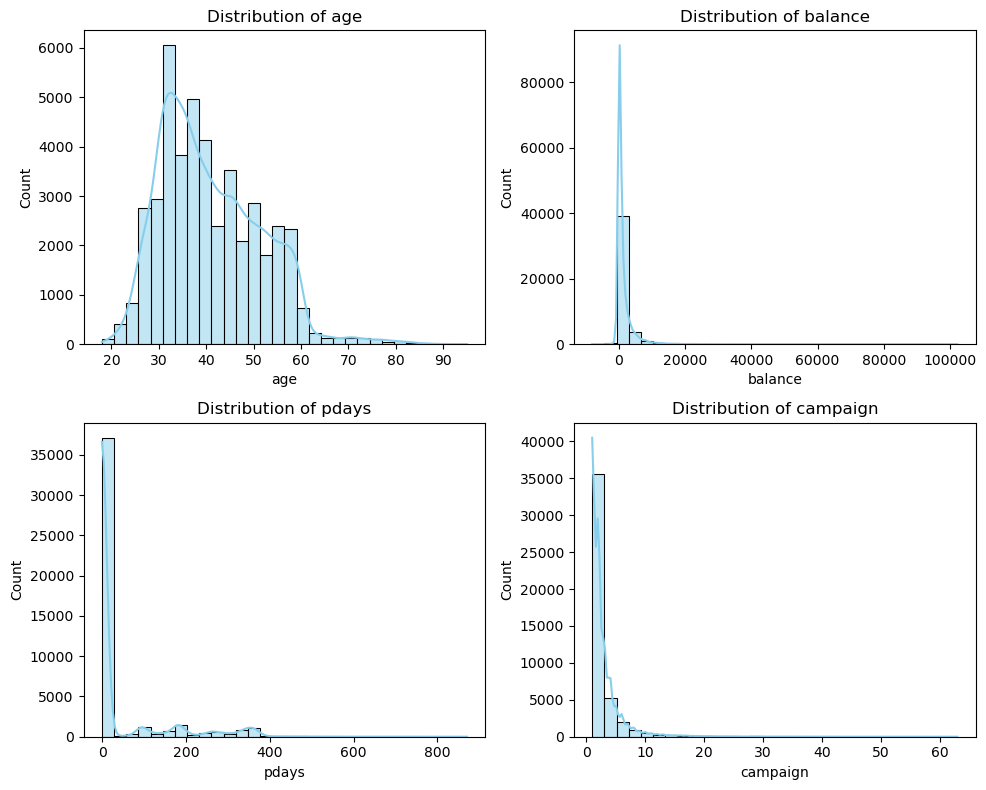


EDA: Boxplots of Numeric Features



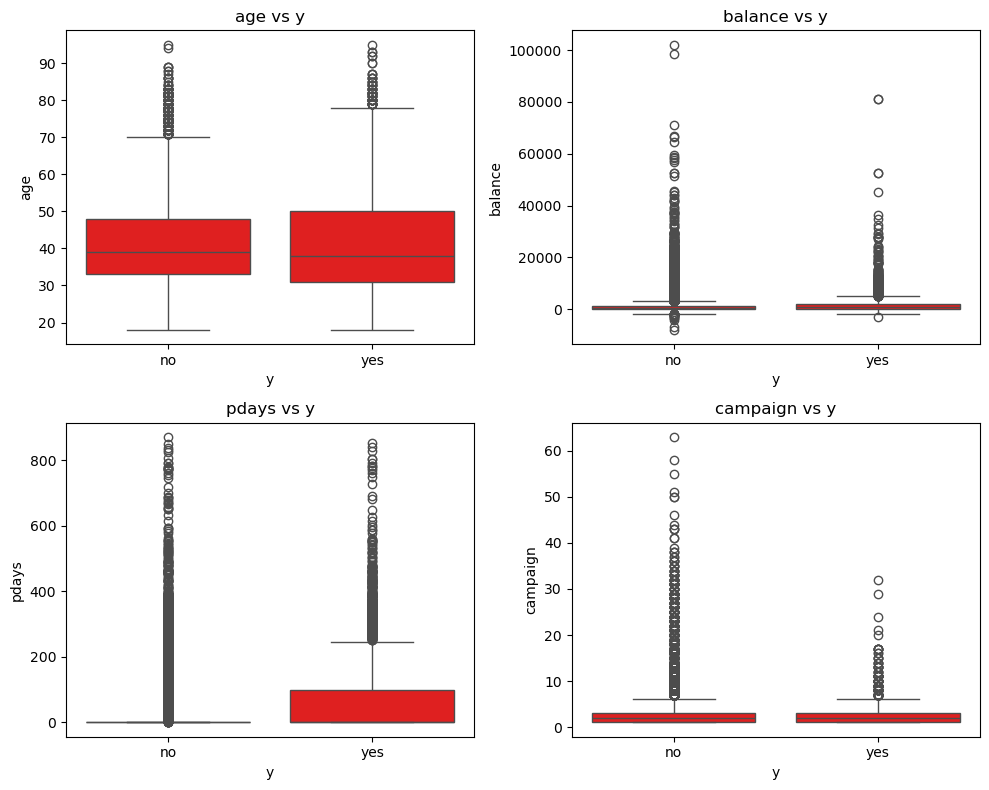


EDA: Countplots of Categorical Features



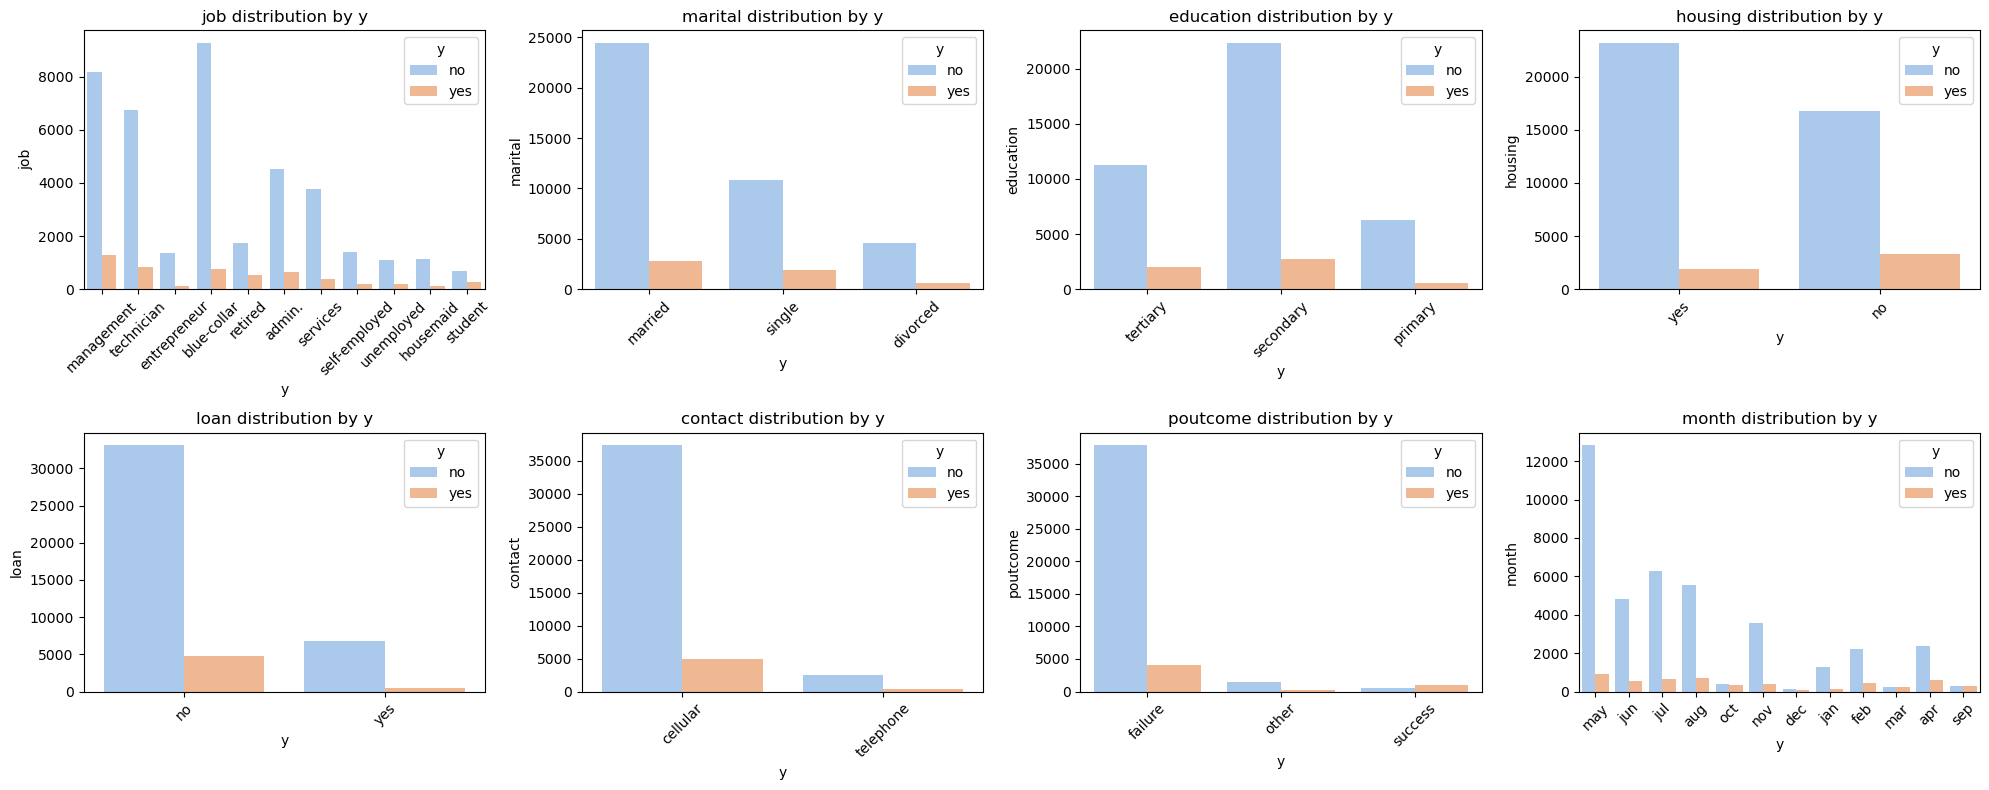

In [54]:
visualization_and_eda(cleaned_df)

<h5 style="color: blue">EDA Summary

- The target variable is **highly imbalanced** (~88% no, 12% yes)
- Features like `balance` and `campaign` are **right-skewed**
- `month`, `job`, and `poutcome` show strong relationship with the target variable
- Some features (e.g., `contact`, `education`) have clearly different distributions based on subscription outcome


<h3 style="color: #006400">Feature Engineering & Preprocessing




Log Transformation Applied to 'campaign' (skewness=1.10)
Log Transformation Applied to 'balance' (skewness=1.07)


Dataset Shape after preprocessing: (45211, 18)
Any Missing Values After Preprocessing..? and have  age                  0
job                  0
marital              0
education            0
default              0
balance              0
housing              0
loan                 0
contact              0
month                0
campaign             0
pdays                0
previous             0
poutcome             0
y                    0
housing_loan         0
contact_frequency    0
success_ratio        0
dtype: int64

Heat Map: Correlation analysis



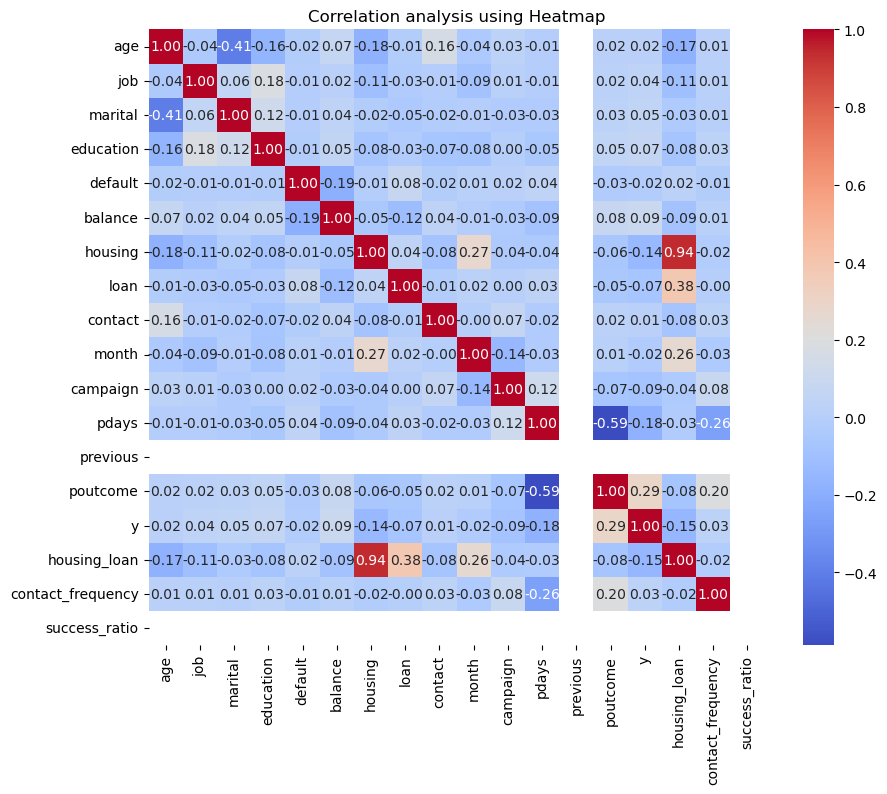

In [57]:
processed_df = bank_dataset_preprocessing(cleaned_df.copy())
correlation_analysis(processed_df)

<h5 style="color: blue">Heatmap Summary

- The target `y` has modest correlation with `poutcome`, `contact_frequency`, and `month`.
- Most features are not strongly correlated with each other, which is good for avoiding multicollinearity.


<h3 style="color: #006400"> Modeling — Training Baseline Models

Shape of the Features: (45211, 17)
Shape of the Target: (45211,)


Shape of Train dataset: (28934, 17)
Shape of Validation dataset: (7234, 17)
Shape of Test dataset: (9043, 17)

 Distribution of class afte balancing using SMOTE:
y
1    25549
0    25549
Name: count, dtype: int64


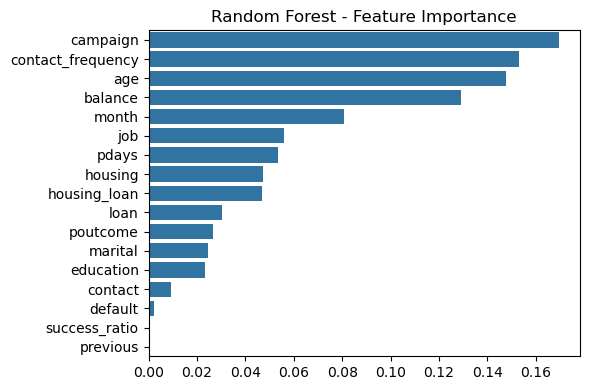

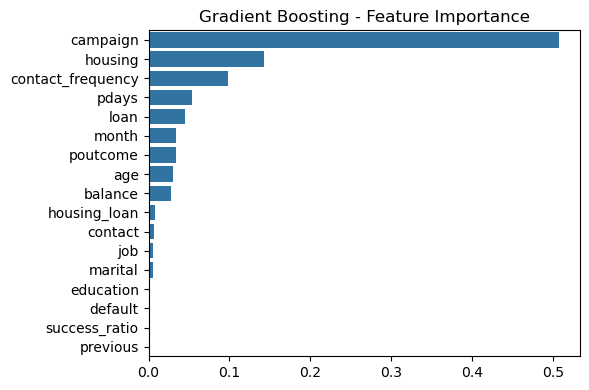

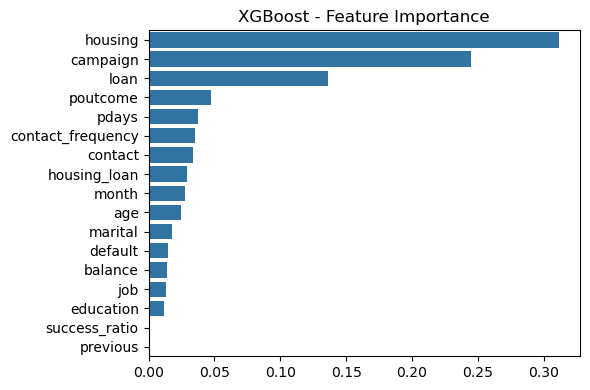

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.699,0.207,0.558,0.302,0.686
1,Random Forest,0.865,0.406,0.326,0.362,0.723
2,Gradient Boosting,0.868,0.428,0.389,0.407,0.729
3,XGBoost,0.876,0.457,0.326,0.381,0.732


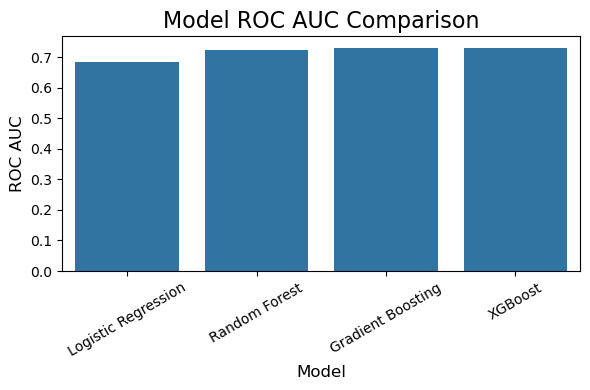

In [60]:
results = modeling_function(processed_df.copy())

<h5 style="color: blue">Baseline Model Training and Evaluation Summary

- **XGBoost** achieved the highest ROC AUC of **0.732**, closely followed by Gradient Boosting.
- All models show **lower recall** on the minority class, suggesting potential for threshold tuning or further optimization.
- ROC AUC Bar Chart: Highlights superior performance of ensemble models like Random Forest, Gradient Boosting, XGBoost
- Most influential features: `campaign`, `housing`, `contact_frequency`, `loan`, `pdays`


<h3 style="color: #006400"> Hyperparameter Tuning & Final Evaluation

In [63]:
tuned_results = hypertuning_function(
    results["X_train"], results["y_train"],
    results["X_val"], results["y_val"],
    results["X_test"], results["y_test"]
)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best XGBoost Parameters:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
ROC AUC (CV): 0.9570
Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best Gradient Boosting Parameters:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
ROC AUC (CV): 0.9592


In [64]:
hypertuned_model_evaluation(
    {name: result["model"] for name, result in tuned_results.items()},
    results["X_test"], results["y_test"]
)


Final Evaluation on Test Set

XGBoost Tuned - Test ROC AUC: 0.7351
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7985
           1       0.49      0.31      0.38      1058

    accuracy                           0.88      9043
   macro avg       0.70      0.63      0.66      9043
weighted avg       0.86      0.88      0.87      9043


Gradient Boosting Tuned - Test ROC AUC: 0.7329
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7985
           1       0.47      0.29      0.36      1058

    accuracy                           0.88      9043
   macro avg       0.69      0.62      0.64      9043
weighted avg       0.86      0.88      0.87      9043



<h3 style="color: #006400">Final Evaluation on Test Set</h3>

I have evaluated the tuned models on the unseen test set. The following are the result

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|--------------------|----------|-----------|--------|----------|---------|
| **XGBoost (Tuned)**         | 0.88     | 0.49      | 0.31   | 0.38     | 0.735   |
| **Gradient Boosting (Tuned)** | 0.88     | 0.47      | 0.29   | 0.36     | 0.733   |



<h1 style="color: red">Key Insights</h1>

- The **tuned XGBoost model** achieved the best performance with ROC AUC = 0.735 on the test set.
- Both models maintained high overall accuracy (0.88).
- The model performs well on the majority class, but recall on the minority class is still low (~30%).
- Feature importance indicates that `month`, `poutcome`, `campaign`, and `contact_frequency` are strong predictors.
- SMOTE improved recall, but there’s still a trade-off between precision and recall.


<h1 style="color: red">Summary</h1>

This project demonstrates a complete machine learning pipeline for handling real-world class imbalance and tabular data modeling.

- Full EDA, preprocessing, and feature engineering
- Multiple models with tuning
- Final ROC AUC: 0.735 (XGBoost)
- - **XGBoost** is selected as the final model for deployment or reporting due to its stronger test set performance.

---- Next Steps to be achived---
- Improve minority class recall 
- Try SHAP/LIME for explainability
- Deploy model 

